In [142]:
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import time
import sys
import matplotlib.pyplot as plt

def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return np.array((m1,m2))
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))

'''my Tmodel(considering gas (SI))'''
def k_1cal(m_1,m_2):
    return 64.0*np.power(sciconsts.G,3.0)*m_1*m_2*(m_1+m_2)/5.0/np.power(sciconsts.c,5.0)
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acalgas(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def freq_tgas(t,m_1,m_2,t_gas,t_0):
    k_1=k_1cal(m_1,m_2)
    a_ft=acalgas(t,k_1,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt((m_1+m_2)*sciconsts.G)*np.power(a_ft,-1.5)
def phi_tgas(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_tgas(x,m_1,m_2,t_gas,t_0),0,t)[0]
def hgas(t,m_1,m_2,t_gas,t_0,phi):
    k_1=k_1cal(m_1,m_2)
    return m_1*m_2/acalgas(t,k_1,t_gas,t_0)*np.cos(phi)
'''my Tmode not considering gas'''
def acalvac(t,k_1,t_c):
    return np.power(4*k_1*(t_c-t),0.25)
def freq_tvac(t,m_1,m_2,t_c):
    avt=acalvac(t,k_1cal(m_1,m_2),t_c)
    return np.sqrt(sciconsts.G*(m_1+m_2))/sciconsts.pi*np.power(avt,-1.5)
def phi_tvac(t,m_1,m_2,t_c):
    cm2=chirp_mass(m_1,m_2)
    return -2*np.power(np.power(sciconsts.c,3.0)/5.0/cm2/sciconsts.G*(t_c-t),5.0/8.0)
def hvac(t,m_1,m_2,t_c,phi_c):
    return  m_1*m_2/acalvac(t,k_1cal(m_1,m_2),t_c)*np.cos(phi_tvac(t,m_1,m_2,t_c)+phi_c)
#phi_c[0,2pi]
def f_jugg(t_c,m_1,m_2):
    return (freq_tvac(0,m_1,m_2,t_c),freq_tvac(4*years,m_1,m_2,t_c))
def t_fvac(f,m_c,t_c):
    sci1=np.power(sciconsts.c,3.0)/5.0/m_c/sciconsts.G
    return t_c-np.power(8.0*sciconsts.pi*f/5.0,-8.0/3.0)*np.power(sci1,5.0/3.0)
def tlimit(m_c,fi,ff):
    sci1=np.power(sciconsts.c,3.0)/5.0/m_c/sciconsts.G
    a=np.array((np.power(8.0*sciconsts.pi*fi/5.0,-8.0/3.0)*np.power(sci1,5.0/3.0),4*years+np.power(8.0*sciconsts.pi*ff/5.0,-8.0/3.0)*np.power(sci1,5.0/3.0)))
    return [a.min(),a.max()]
def tcn_decide(mc,fi,ff,acu):
    return ((tlimit(mc,fi,ff)[1]-tlimit(mc,figas,ffgas)[0])/tlimit(mc,fi,ff)[1])//acu+1
def noden_cal(mc,phinum,tcn_racu,fi,ff):
    mcn=mc.size
    i=0
    sum1=0
    while i<mcn:
        sum1=sum1+tcn_decide(mc[i],fi,ff,tcn_racu)
        i=i+1
    return sum1*phinum


def pow2(a):
    b=1
    i=True
    while i:
        b=2*b
        if b>a:
            i=False
    return b
'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)

def testf(tbegin,tend):
    return abs(freq_tgas(tend,m_1g,m_2g,t_gas,t_0g)-freq_tgas(tbegin,m_1g,m_2g,t_gas,t_0g))/freq_tgas(tbegin,m_1g,m_2g,t_gas,t_0g)

def domjugg(f1,f2,del_f):
    a=np.array([f1,f2])
    t=del_f+a.min()-a.max()
    return t

In [131]:
fname=sys.argv[0]+'value.txt'
#consts setting
m_sun=1.9891e30
years=365*24*3600.0
pc=3.261*sciconsts.light_year
t_scale=4*years
#gas cal
m_1g=10*m_sun
m_2g=10*m_sun
k_1g=k_1cal(m_1g,m_2g)
t_gas=1000.0*years
a_0=3.0e8
t_0g=t_0cal(m_1g,m_2g,t_gas,a_0)
#(t_scale*0.01*4,N/0.01/t_scale,t_scale) 
figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
ffgas=freq_tgas(t_scale,m_1g,m_2g,t_gas,t_0g)
#tdomain interp1d
tphi=np.linspace(0,t_scale,10000)
i=0
workphi=np.zeros(10000)
while i<10000:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)

In [200]:
tn=50
Ng=10000000/tn #
del_t=t_scale/tn
del_f=1/del_t
print 'del_t',del_t,'del_f',del_f
fs=np.linspace(0,Ng//2*del_f,num=Ng//2)
hf_g=np.zeros(Ng//2)
phi_g=np.zeros(Ng//2)
hf_v=np.zeros(Ng//2)
phi_v=np.zeros(Ng//2)
snf=np.zeros(Ng//2)
for i in range(0,Ng//2):
    snf[i]=S_n_lisa(fs[i])
r=1e7*pc
S=1.0/(r)*np.power(sciconsts.G,2)/np.power(sciconsts.c,4.0)*np.sqrt(384.0/5)*np.power(sciconsts.pi,2.0/3.0)
#

del_t 2522880.0 del_f 3.96372399797e-07


/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in double_scalars


In [222]:
#parameters changes
mcnum=10
acu=0.0001
mt=37.21
mcs=np.linspace(37*m_sun,38*m_sun,mcnum)
data=np.zeros((mcnum,2))
noden=noden_cal(mcs,1,0.0001,figas,ffgas)
print 'cal start,node=',noden
sys.stdout.flush()
mcn=0
tb=time.clock()

i=0
tbegin=0
tend=t_scale/tn
h12i=0
while i<tn:
    #gas
    t=np.linspace(tbegin,tend,num=Ng)
    ht=hgas(t,m_1g,m_2g,t_gas,t_0g,phimo(t))*S
    hf=fft.fft(ht)[0:Ng//2]*2.0/Ng
    hf_abs=abs(hf)
    hf_g=hf_g+hf_abs
    phi_g=phi_g+np.arctan(hf.imag/hf.real)[0:Ng//2]
    tbegin=tbegin+del_t
    tend=tend+del_t
    i=i+1
A=np.sqrt(sci_integrate.simps(hf_g*hf_g/snf,fs))
print A
while mcn<mcnum:
    ffmax=0.0
    m1v=solvem(mcs[mcn],0.25)[0]
    m2v=solvem(mcs[mcn],0.25)[1]
    tcl=tlimit(mcs[mcn],figas,ffgas)
    tcnum=tcn_decide(mcs[mcn],figas,ffgas,acu)
    tcl_sp=np.linspace(tcl[0],tcl[1],tcnum)
    tcn=0
    while tcn<tcnum:
        tc=tcl_sp[tcn]
        i=0
        tbegin=0
        tend=t_scale/tn
        while i<tn:
            t=np.linspace(tbegin,tend,num=Ng)
            htv=hvac(t,m1v,m2v,tc,0)*S
            hfv=fft.fft(htv)[0:Ng//2]*2.0/Ng
            hfv_abs=abs(hfv)
            hf_v=hf_v+hfv_abs
            phi_v=phi_v+np.arctan(hfv.imag/hfv.real)[0:Ng//2]
            tbegin=tbegin+del_t
            tend=tend+del_t
            i=i+1
        B=np.sqrt(sci_integrate.simps(hf_v*hf_v/snf,fs))
        phivp=np.linspace(0,2*sciconsts.pi,200)
        AB=0
        for phiv1 in phivp:
            ABi=sci_integrate.simps(hf_v*hf_g*np.cos(phi_g-phi_v+phiv1)/snf,fs)
            if ABi>AB:
                AB=ABi
        FF=AB/B/A
        print FF
        if FF>ffmax:
            ffmax=FF
        sys.stdout.flush()
        tcn=tcn+1
    #data[mcn,0]=mcs[mcn]/m_sun
    #data[mcn,1]=ffmax
    print ffmax,mcs[mcn]/m_sun
    mcn=mcn+1
#np.savetxt(fname,data)
#te=time.clock()
#print 'cal completed!',(te-tb),'s'
sys.stdout.flush()

cal start,node= 30.0
0.000440194796641
0.100597169809
0.10574983976
0.0541191012673
0.10574983976 37.0
0.0945458549093
0.113716879205
0.113716879205 37.1111111111
0.188568118485
0.188568118485 37.2222222222
0.1606373097
0.1606373097 37.3333333333
0.137772661649
0.269940571973
0.269940571973 37.4444444444
0.0986867399039
0.187138410212
0.0869516426922
0.187138410212 37.5555555556
0.217884346795
0.0759278994709
0.110603148725
0.217884346795 37.6666666667
0.127059168471
0.0842268034367
0.175382959462
0.166480550025
0.175382959462 37.7777777778
0.0188059959068
0.355372524002
0.115255713124
0.162787786495
0.127610658499
0.355372524002 37.8888888889
0.0669400062823
0.267067786942
0.204617426679
0.0790179015469
0.0835454155828
0.0713313689508
0.267067786942 38.0


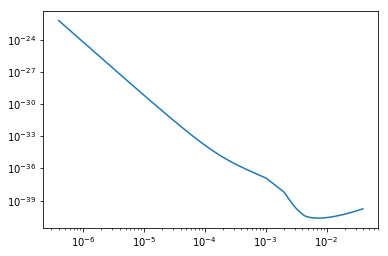

In [193]:
plt.plot(fs,snf)
plt.xscale('log')
plt.yscale('log')
#plt.plot(fs,phiv)
#plt.xlim(0.00315,0.0032)
plt.show()

In [91]:
i=0
while i<tn:
    
    i=i+1

nan

In [ ]:
mcnum=10
acu=0.0001
mcs=np.linspace(37*m_sun,38*m_sun,mcnum)
noden=noden_cal(mcs,1,0.0001,figas,ffgas)
print 'cal start,node=',noden,'esi_t=',node*5/3600,'h'
sys.stdout.flush()
mcn=0
tb=time.clock()
A=np.sqrt(sci_integrate.quad(lambda x:np.power(hgas(x,m_1g,m_2g,t_gas,t_0g,phimo(x)),2.0),0,4*years,limit=1500,epsabs=0.005))
while mcn<mcnum:
    ffmax=0.0
    m1v=solvem(mcs[mcn],0.25)[0]
    m2v=solvem(mcs[mcn],0.25)[1]
    tcl=tlimit(mcs[mcn],figas,ffgas)
    tcnum=tcn_decide(mcs[mcn],figas,ffgas,acu)
    tcl_sp=np.linspace(tcl[0],tcl[1],tcnum)
    tcn=0
    while tcn<tcnum:
        tc=tcl_sp[tcn]
        B=np.sqrt(sci_integrate.quad(lambda x:np.power(hvac(x,m1v,m2v,tc,0),2.0),0,4*years,limit=1500,epsabs=0.005))
        AB=sci_integrate.quad(lambda x:hvac(x,m1v,m2v,tc,0)*hgas(x,m_1g,m_2g,t_gas,t_0g,phimo(x)),0,4*years,limit=1500,epsabs=0.005)
        FF=AB/A/B
        if FF>ffmax:
            ffmax=FF
        tcn=tcn+1
    print ffmax,mcs[mcn]/m_sun
    mcn=mcn+1
#np.savetxt(fname,data)
#te=time.clock()
#print 'cal completed!',(te-tb),'s'
sys.stdout.flush()

In [248]:
m1v=37.21*m_sun
m2v=m1v
phiv=np.linspace(0,2*sciconsts.pi,30)
i2=0
A=sci_integrate.quad(lambda x:np.power(hgas(x,m_1g,m_2g,t_gas,t_0g,phimo(x)),2.0),0,4*years,limit=500)
Aval=np.sqrt(A[0])
Aerr=0.5/Aval*A[1]
while i2<30:
    t1=time.clock()
    B=sci_integrate.quad(lambda x:np.power(hvac(x,m1v,m2v,tc,phiv[i2]),2.0),0,4*years,limit=500)
    Bval=np.sqrt(B[0])
    Berr=0.5/Bval*B[1]
    AB=sci_integrate.quad(lambda x:hvac(x,m1v,m2v,tc,phiv[i2])*hgas(x,m_1g,m_2g,t_gas,t_0g,phimo(x)),0,4*years,limit=1500,epsabs=0.005)
    ff=AB[0]/Aval/Bval
    err=abs(1/Aval/Bval*AB[1])+abs(AB[0]/Aval/Aval/Bval*Aerr)+abs(AB[0]/Aval/Bval/Bval*Berr)
    t2=time.clock()
    print ff,err/ff,AB[1]/AB[0],Aerr/Aval,Berr/Bval,t2-t1
    i2=i2+1

0.0153224519207 0.131565742363 0.0873123104061 0.0122777516726 0.0319756802839 3.817619
0.0155077395129 0.636148338762 0.610144738618 0.0122777516726 0.013725848472 3.681207
0.00345671924817 16.3879570596 16.3510450019 0.0122777516726 0.0246343060246 3.928471
-0.0068700708568 -2.36076160183 -2.34400531607 0.0122777516726 0.00447853408343 3.813649
-0.0192626088546 -0.606954143532 -0.5792762315 0.0122777516726 0.015400160359 3.897812
-0.0183789091898 -1.08357112617 -1.06037548821 0.0122777516726 0.0109178862865 3.682991
-0.0092692405185 -3.16614548237 -3.14136903064 0.0122777516726 0.012498700057 3.722505
-0.00751771459205 -6.70461777683 -6.67211831538 0.0122777516726 0.020221709781 3.699679
-0.00990864393141 -3.60288661368 -3.57648014763 0.0122777516726 0.0141287143742 3.775618
-0.0125807122878 -3.49891953133 -3.47455701248 0.0122777516726 0.0120847671788 3.694483
-0.0146552227858 -1.1401373683 -1.12060170203 0.0122777516726 0.00725791459337 3.639969
-0.0153955482713 -0.617530256844 -0.

KeyboardInterrupt: 

In [236]:
sci_integrate.quad(lambda x:np.power(hgas(x,m_1g,m_2g,t_gas,t_0g,phimo(x)),2.0),0,4*years,limit=100,epsabs=0.005)

/Users/shyn/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


(1.1450142764625034e+116, 9.079254201793897e+114)

In [235]:
m1v/m_sun

43.650537489887327

In [22]:
b=rhogas*rhogas
np.sqrt(b.sum())

0.0027851625044130659

In [38]:
np.where(hf_abs==c1)[0][0]

7964

In [32]:
np.where(hf==c1)

(array([], dtype=int64),)

In [22]:
np.sqrt(1.0/(1.5/t_gas*figas))/years

0.0818365738661503

In [14]:
#tdomain point cal
Tg=t_scale/Ng
hfgas=hgas(t,m_1g,m_2g,t_gas,t_0g,phimo(t))
#fft
hfgas1=fft.fft(hfgas)
hfgas_abs=abs(hfgas1)
hfgas_angle=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
hfgas2=2.0/Ng*hfgas_abs[0:Ng//2]
hs=sci_interpolate.interp1d(xs,hfgas2)
anglegas=sci_interpolate.interp1d(xs,hfgas_angle)
A=sci_integrate.quad(lambda x:4*np.power(hs(x),2.0)/S_n_lisa(x),figas,ffgas,limit=1500,epsabs=0.005)
Aval=np.sqrt(A[0])
Aerr=0.5/Aval*A[1]

/Users/shyn/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (2000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


(1.102917297223318e+116, 9.413244045256381e+113)

In [8]:
S_n_lisa((figas+ffgas)/2)/S_n_lisa(ffgas)

1.0208135196378185

In [10]:
a=sci_integrate.quad(lambda x:np.power(hgas(x,m_1g,m_2g,t_gas,t_0g,phimo(x)),2.0),0,4*years,limit=2000,epsabs=0.005)
print a

(1.102917297223318e+116, 9.413244045256381e+113)


/Users/shyn/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (2000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [13]:
np.sqrt(4*a[0]/S_n_lisa((figas+ffgas)/2))*S

51.5236350626666

In [12]:
b

2.3514524589843899e+156

In [3]:
#parameters changes
mcnum=1000
phinum=30
acu=0.0001
mcs=np.linspace(37.7*m_sun,37.8*m_sun,mcnum)
phis=np.linspace(0,2*sciconsts.pi,phinum)
data=np.zeros((mcnum,3))
noden=noden_cal(mcs,phinum,0.0001,figas,ffgas)
print 'cal start,node=',noden,' esiT=',noden/3600.0*10,'h'
sys.stdout.flush()
mcn=0
pn=0.0
tb=time.clock()
while mcn<mcnum:
    ffmax=0.0
    errmax=0.0
    m1v=solvem(mcs[mcn],0.25)[0]
    m2v=solvem(mcs[mcn],0.25)[1]
    tcl=tlimit(mcs[mcn],figas,ffgas)
    tcnum=tcn_decide(mcs[mcn],figas,ffgas,acu)
    tcl_sp=np.linspace(tcl[0],tcl[1],tcnum)
    tcn=0
    while tcn<tcnum:
        phin=0
        while phin<phinum:
            ti=time.clock()
            fivac=freq_tvac(0,m1v,m2v,tcl_sp[tcn])
            ffvac=freq_tvac(4*years,m1v,m2v,tcl_sp[tcn])
            Ng=int(t_scale*ffvac*4)
            Ng=pow2(Ng)
            T=t_scale/Ng
            xs=np.linspace(0,1/2.0/T,num=Ng//2)
            t=np.linspace(0,t_scale,num=Ng//2)
            hvt=hvac(t,m1v,m2v,tcl_sp[tcn],phis[phin])
            hfvac1=fft.fft(hvt)
            hfvac_abs=abs(hfvac1)
            hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
            anglevac=sci_interpolate.interp1d(xs,hfvac_angle)
            hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]
            hvacs=sci_interpolate.interp1d(xs,hfvac2)
            d=(np.array((fivac,figas)).max(),np.array((ffvac,ffgas)).min())
            B=sci_integrate.quad(lambda x:4*np.power(hvacs(x),2.0)/S_n_lisa(x),fivac,ffvac,limit=1500,epsabs=0.005)
            Bval=np.sqrt(B[0])
            Berr=0.5/Bval*B[1]
            AB=sci_integrate.quad(lambda x:4*hvacs(x)*hs(x)/S_n_lisa(x)*np.cos(anglegas(x)-anglevac(x)),d[0],d[1],limit=1500,epsabs=0.005)
            ff=AB[0]/Aval/Bval
            err=abs(1/Aval/Bval*AB[1])+abs(AB[0]/Aval/Aval/Bval*Aerr)+abs(AB[0]/Aval/Bval/Bval*Berr)
            tf=time.clock()
            if ff>ffmax:
                ffmax=ff
                errmax=err
            print pn,round(tf-ti,2),ff
            sys.stdout.flush()
            phin=phin+1
            pn=pn+1
        tcn=tcn+1
    data[mcn,0]=mcs[mcn]/m_sun
    data[mcn,1]=ffmax
    data[mcn,2]=errmax
    mcn=mcn+1
np.savetxt(fname,data)
te=time.clock()
print 'cal completed!',(te-tb)/3600,'h'
sys.stdout.flush()

cal start,node= 81060.0  esiT= 225.166666667 h


/Users/shyn/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


0.0 9.79 0.546507612269


/Users/shyn/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (1500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


1.0 8.88 0.564566794952
2.0 8.09 0.576873614782
3.0 9.9 0.585714238849
4.0 10.36 0.573606072631
5.0 9.76 0.569227173532
6.0 9.24 0.568656896348
7.0 9.04 0.543968039218
8.0 9.07 0.541892419177
9.0 8.96 0.541953143038
10.0 8.95 0.564437902652
11.0 9.09 0.570889041149
12.0 8.8 0.583152008159
13.0 9.17 0.585786356618
14.0 8.98 0.584476591994
15.0 8.72 0.565042331264
16.0 2.24 0.553483982778
17.0 8.27 0.545586515961
18.0 8.21 0.539355681272
19.0 11.4 0.546507612256
20.0 12.77 0.574439394677
21.0 12.56 0.533978240886
22.0 11.69 0.521011822594
23.0 10.37 0.517912370132
24.0 9.15 0.535409020959
25.0 9.84 0.562644226549


KeyboardInterrupt: 

0.58859260456291229

0.0012955710025295037

In [17]:
mcnum=200
phinum=30
mcs=np.linspace(36*m_sun,38*m_sun,mcnum)
phis=np.linspace(0,2*sciconsts.pi,phinum)
data=np.zeros((mcnum,3))
noden=noden_cal(mcs,phinum,0.0001,figas,ffgas)
noden,noden/360

(28260.0, 78.5)

In [6]:
sciconsts.G/np.power(sciconsts.c,4.0)

8.2624452818656455e-45

In [12]:
10000000/60

166666

In [56]:
a.sum()

30

In [128]:
for i in range(0,50):
    print i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [226]:
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import time
import sys
import matplotlib.pyplot as plt
def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return np.array((m1,m2))
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))

'''my Tmodel(considering gas (SI))'''
def k_1cal(m_1,m_2):
    return 64.0*np.power(sciconsts.G,3.0)*m_1*m_2*(m_1+m_2)/5.0/np.power(sciconsts.c,5.0)
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acalgas(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def freq_tgas(t,m_1,m_2,t_gas,t_0):
    k_1=k_1cal(m_1,m_2)
    a_ft=acalgas(t,k_1,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt((m_1+m_2)*sciconsts.G)*np.power(a_ft,-1.5)
def phi_tgas(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_tgas(x,m_1,m_2,t_gas,t_0),0,t)[0]
def hgas(t,m_1,m_2,t_gas,t_0,phi):
    k_1=k_1cal(m_1,m_2)
    return m_1*m_2/acalgas(t,k_1,t_gas,t_0)*np.cos(phi)
'''my Tmode not considering gas'''
def acalvac(t,k_1,t_c):
    return np.power(4*k_1*(t_c-t),0.25)
def freq_tvac(t,m_1,m_2,t_c):
    avt=acalvac(t,k_1cal(m_1,m_2),t_c)
    return np.sqrt(sciconsts.G*(m_1+m_2))/sciconsts.pi*np.power(avt,-1.5)
def phi_tvac(t,m_1,m_2,t_c):
    cm2=chirp_mass(m_1,m_2)
    return -2*np.power(np.power(sciconsts.c,3.0)/5.0/cm2/sciconsts.G*(t_c-t),5.0/8.0)
def hvac(t,m_1,m_2,t_c,phi_c):
    return  m_1*m_2/acalvac(t,k_1cal(m_1,m_2),t_c)*np.cos(phi_tvac(t,m_1,m_2,t_c)+phi_c)
#phi_c[0,2pi]
def f_jugg(t_c,m_1,m_2):
    return (freq_tvac(0,m_1,m_2,t_c),freq_tvac(4*years,m_1,m_2,t_c))
def t_fvac(f,m_c,t_c):
    sci1=np.power(sciconsts.c,3.0)/5.0/m_c/sciconsts.G
    return t_c-np.power(8.0*sciconsts.pi*f/5.0,-8.0/3.0)*np.power(sci1,5.0/3.0)
def tlimit(m_c,fi,ff):
    sci1=np.power(sciconsts.c,3.0)/5.0/m_c/sciconsts.G
    a=np.array((np.power(8.0*sciconsts.pi*fi/5.0,-8.0/3.0)*np.power(sci1,5.0/3.0),4*years+np.power(8.0*sciconsts.pi*ff/5.0,-8.0/3.0)*np.power(sci1,5.0/3.0)))
    return [a.min(),a.max()]
def tcn_decide(mc,fi,ff,acu):
    return ((tlimit(mc,fi,ff)[1]-tlimit(mc,figas,ffgas)[0])/tlimit(mc,fi,ff)[1])//acu+1
def noden_cal(mc,phinum,tcn_racu,fi,ff):
    mcn=mc.size
    i=0
    sum1=0
    while i<mcn:
        sum1=sum1+tcn_decide(mc[i],fi,ff,tcn_racu)
        i=i+1
    return sum1*phinum


def pow2(a):
    b=1
    i=True
    while i:
        b=2*b
        if b>a:
            i=False
    return b
'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)

def testf(tbegin,tend):
    return abs(freq_tgas(tend,m_1g,m_2g,t_gas,t_0g)-freq_tgas(tbegin,m_1g,m_2g,t_gas,t_0g))/freq_tgas(tbegin,m_1g,m_2g,t_gas,t_0g)

def domjugg(f1,f2,del_f):
    a=np.array([f1,f2])
    t=del_f+a.min()-a.max()
    return t

fname=sys.argv[0]+'value.txt'
#consts setting
m_sun=1.9891e30
years=365*24*3600.0
pc=3.261*sciconsts.light_year
t_scale=4*years
#gas cal
m_1g=10*m_sun
m_2g=10*m_sun
k_1g=k_1cal(m_1g,m_2g)
t_gas=1000.0*years
a_0=3.0e8
t_0g=t_0cal(m_1g,m_2g,t_gas,a_0)
#(t_scale*0.01*4,N/0.01/t_scale,t_scale) 
figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
ffgas=freq_tgas(t_scale,m_1g,m_2g,t_gas,t_0g)
#tdomain interp1d
tphi=np.linspace(0,t_scale,10000)
i=0
workphi=np.zeros(10000)
while i<10000:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)
tn=50
Ng=10000000/tn #
del_t=t_scale/tn
del_f=1/del_t
print 'del_t',del_t,'del_f',del_f
fs=np.linspace(0,Ng//2*del_f,num=Ng//2)
hf_g=np.zeros(Ng//2)
phi_g=np.zeros(Ng//2)
hf_v=np.zeros(Ng//2)
phi_v=np.zeros(Ng//2)
snf=np.zeros(Ng//2)
for i in range(0,Ng//2):
    snf[i]=S_n_lisa(fs[i])
r=1e7*pc
S=1.0/(r)*np.power(sciconsts.G,2)/np.power(sciconsts.c,4.0)*np.sqrt(384.0/5)*np.power(sciconsts.pi,2.0/3.0)
mcnum=10
acu=0.0001
mcs=np.linspace(37*m_sun,38*m_sun,mcnum)
noden=noden_cal(mcs,1,0.0001,figas,ffgas)
print 'cal start,node=',noden,'esi_t=',noden*5/3600,'h'
sys.stdout.flush()
mcn=0
tb=time.clock()
A=np.sqrt(sci_integrate.quad(lambda x:np.power(hgas(x,m_1g,m_2g,t_gas,t_0g,phimo(x)),2.0),0,4*years,limit=1500,epsabs=0.005))
while mcn<mcnum:
    ffmax=0.0
    m1v=solvem(mcs[mcn],0.25)[0]
    m2v=solvem(mcs[mcn],0.25)[1]
    tcl=tlimit(mcs[mcn],figas,ffgas)
    tcnum=tcn_decide(mcs[mcn],figas,ffgas,acu)
    tcl_sp=np.linspace(tcl[0],tcl[1],tcnum)
    tcn=0
    while tcn<tcnum:
        tc=tcl_sp[tcn]
        B=np.sqrt(sci_integrate.quad(lambda x:np.power(hvac(x,m1v,m2v,tc,0),2.0),0,4*years,limit=1500,epsabs=0.005))
        AB=sci_integrate.quad(lambda x:hvac(x,m1v,m2v,tc,0)*hgas(x,m_1g,m_2g,t_gas,t_0g,phimo(x)),0,4*years,limit=1500,epsabs=0.005)
        FF=AB[0]/A[0]/B[0]
        if FF>ffmax:
            ffmax=FF
        tcn=tcn+1
    print ffmax,mcs[mcn]/m_sun
    mcn=mcn+1
#np.savetxt(fname,data)
#te=time.clock()
#print 'cal completed!',(te-tb),'s'
sys.stdout.flush()

del_t 2522880.0 del_f 3.96372399797e-07


/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in double_scalars


cal start,node= 30.0 esi_t= 0.0416666666667 h
0.174226157135 37.0
0.0 37.1111111111
0.21799994908 37.2222222222
0.0 37.3333333333
0.305307020451 37.4444444444
0.127601771516 37.5555555556
0.0638732591607 37.6666666667
0.136961868415 37.7777777778
0.0411271577792 37.8888888889
0.0842641081204 38.0


array([  1.49949300e+118,   4.75958354e+116])